In [64]:
# Standard library import
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=all info, 1=info, 2=warning info, 3=error info
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_VMODULE'] = 'cuda_executor=0'
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import re
import time
from difflib import get_close_matches
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings
import gradio as gr
import math
import keras_tuner as kt
import networkx as nx
 
# Scientific computing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import scipy.sparse as sp

# Natural language processing libraries 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# Machine learning and model libraries 
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sk_train_test_split, KFold
from sklearn.decomposition import PCA
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split as sp_train_test_split
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [65]:
# read files
ratings = pd.read_csv('rating.csv')
movies = pd.read_csv('movie.csv')
tags = pd.read_csv('tag.csv')
directors = pd.read_csv('imdb_top_1000.csv')

# merge rating.csv and movie.csv by movieID
rating_movie_merged = pd.merge(ratings, movies, on='movieId')

# merge rating.csv and tag.csv
merged_data = pd.merge(rating_movie_merged, tags, on=['movieId','userId'], how='inner')
merged_data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,2011-05-09 16:05:53
1,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,surreal,2011-05-09 16:25:54
2,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,unusual,2011-05-09 16:25:59
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,cute,2011-05-09 16:13:32
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,emotional,2011-05-09 16:13:28


In [66]:
# modify title column format
def process_movie_title(title):
    # Extract the last parentheses if it contains a year 
    match = re.search(r"\(\d{4}\)$", title)  # Match parentheses with a 4-digit number at the end of the title
    year = match.group(0) if match else ""  # Extract the year if present, otherwise keep it empty

    # Remove any parentheses and content in the middle of the title
    title_without_parentheses = re.sub(r"\s*\([^)]*\)\s*", "", title)  # Remove any non-year parentheses in the middle of the title

    # Move "The", "A", or "An" from the end of the title to the beginning if present
    if ', The' in title_without_parentheses:
        title_without_parentheses = 'The ' + title_without_parentheses.replace(', The', '')
    elif ', A' in title_without_parentheses:
        title_without_parentheses = 'A ' + title_without_parentheses.replace(', A', '')
    elif ', An' in title_without_parentheses:
        title_without_parentheses = 'An ' + title_without_parentheses.replace(', An', '')

    # Add the year back to the end of the title (if it was extracted)
    if year:
        title_without_parentheses = f"{title_without_parentheses} {year}"

    return title_without_parentheses.strip()  # Return the final processed title, ensuring no extra spaces

# Apply to the entire dataset
merged_data['title'] = merged_data['title'].apply(process_movie_title)

# Check the processed result
merged_data['title'].head(10)

0      In My Father's Den (2004)
1    The Science of Sleep (2006)
2    The Science of Sleep (2006)
3                     CJ7 (2008)
4                     CJ7 (2008)
5                     CJ7 (2008)
6                     CJ7 (2008)
7                  Frozen (2013)
8                  Frozen (2013)
9                  Frozen (2013)
Name: title, dtype: object

In [67]:
directors.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [68]:
# add director information to merged_data
directors = directors.rename(columns={'Series_Title': 'shared_title', 'Director': 'director'})

# define a function to unite the movie title format for future merging
def extract_movie_name(title):
    return re.sub(r'\s+\(\d{4}\)$', '', title).strip()

# extract movie title
merged_data['shared_title'] = merged_data['title'].apply(extract_movie_name)

# merge merged_data and directors using 'shared_title'
merged_data = pd.merge(merged_data, directors[['shared_title','director']], on='shared_title', how='left')
merged_data['director'] = merged_data['director'].fillna('unknown')
merged_data = merged_data.drop(columns=['shared_title'])
merged_data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,director
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,2011-05-09 16:05:53,unknown
1,65,48082,4.5,2011-05-09 16:26:19,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,surreal,2011-05-09 16:25:54,unknown
2,65,48082,4.5,2011-05-09 16:26:19,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unusual,2011-05-09 16:25:59,unknown
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (2008),Children|Comedy|Sci-Fi,cute,2011-05-09 16:13:32,unknown
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (2008),Children|Comedy|Sci-Fi,emotional,2011-05-09 16:13:28,unknown


In [69]:
# remove extra timestamp
merged_data = merged_data.drop(columns=['timestamp_y']).rename(columns={'timestamp_x': 'timestamp'})
merged_data.head()

,userId,movieId,rating,timestamp,title,genres,tag,director
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,unknown
1,65,48082,4.5,2011-05-09 16:26:19,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,surreal,unknown
2,65,48082,4.5,2011-05-09 16:26:19,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unusual,unknown
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (2008),Children|Comedy|Sci-Fi,cute,unknown
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (2008),Children|Comedy|Sci-Fi,emotional,unknown


In [70]:
# check null value
merged_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          1
director     0
dtype: int64

In [71]:
# mark NaN as 'unknown'
merged_data['tag'] = merged_data['tag'].fillna('unknown')
merged_data.isnull().sum() 

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
director     0
dtype: int64

In [72]:
merged_data.describe()

,userId,movieId,rating
count,391445.000000,391445.000000,391445.000000
mean,67291.897587,32766.306189,3.780652
std,42227.513945,35997.920748,1.024136
min,65.000000,1.000000,0.500000
25%,27898.000000,2502.000000,3.000000
50%,66635.000000,7361.000000,4.000000
75%,106755.000000,63072.000000,4.500000
max,138472.000000,131258.000000,5.000000


In [73]:
# combine different tags under same movie
merged_data = merged_data.groupby(['userId', 'movieId', 'title', 'genres', 'director'], as_index=False).agg({
    'rating': 'mean',
    'timestamp': 'first',
    'tag': lambda x: ', '.join(x)
})

# copy merged_data for future use
merged_data_copy = merged_data.copy()

merged_data.head()

,userId,movieId,title,genres,director,rating,timestamp,tag
0,65,27866,In My Father's Den (2004),Drama,unknown,4.0,2011-05-09 16:05:59,New Zealand
1,65,48082,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unknown,4.5,2011-05-09 16:26:19,"surreal, unusual"
2,65,58652,CJ7 (2008),Children|Comedy|Sci-Fi,unknown,5.0,2011-05-09 16:09:31,"cute, emotional, girls who play boys, Stephen ..."
3,96,106696,Frozen (2013),Adventure|Animation|Comedy|Fantasy|Musical|Rom...,unknown,3.5,2014-03-29 12:48:07,"animation, beautiful, characters, Disney, femi..."
4,121,778,Trainspotting (1996),Comedy|Crime|Drama,Danny Boyle,4.0,2011-03-23 04:00:30,"dark comedy, drugs, Nudity (Full Frontal - Not..."


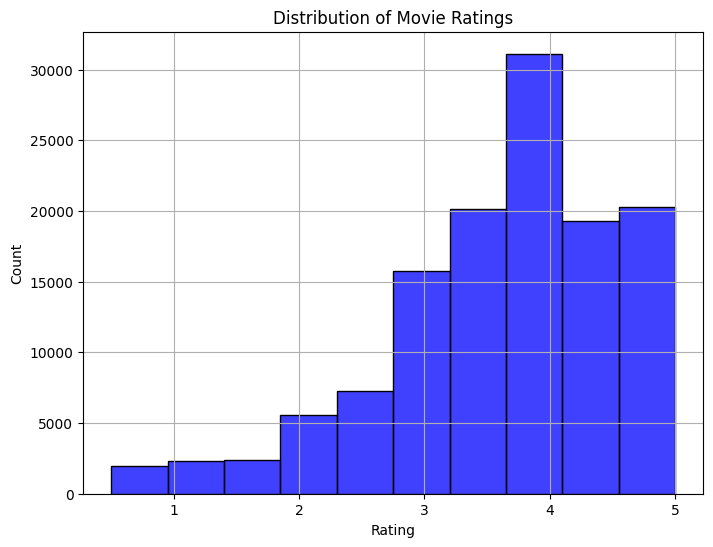

In [74]:
# visualize rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(merged_data['rating'], bins=10, kde=False, color='blue', kde_kws={'bw_adjust': 2})
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

This is a positively skewed distribution, i.e. most of the ratings for movies tend to be high. Many users tend to give high ratings (close to 5) to the movies they like, and fewer users give very low ratings (such as 1).

In [75]:
# split genres col, make each genre a list
merged_data['genres_split'] = merged_data['genres'].str.split('|')

# use explode to show genre as independent row and save the result as a new dataframe
genres_exploded = merged_data.explode('genres_split')

# filter out (no genres listed)
genres_exploded = genres_exploded[genres_exploded['genres_split'] != '(no genres listed)']

# count each genre's appearance
genre_counts = genres_exploded['genres_split'].value_counts()
genre_counts

genres_split
Drama          62926
Comedy         40755
Thriller       35589
Action         33221
Adventure      24075
Romance        22346
Sci-Fi         22114
Crime          22103
Fantasy        14305
Mystery        12883
Horror         11437
Animation       7510
Children        7161
War             6361
IMAX            6271
Musical         4356
Documentary     2961
Western         1872
Film-Noir       1859
Name: count, dtype: int64

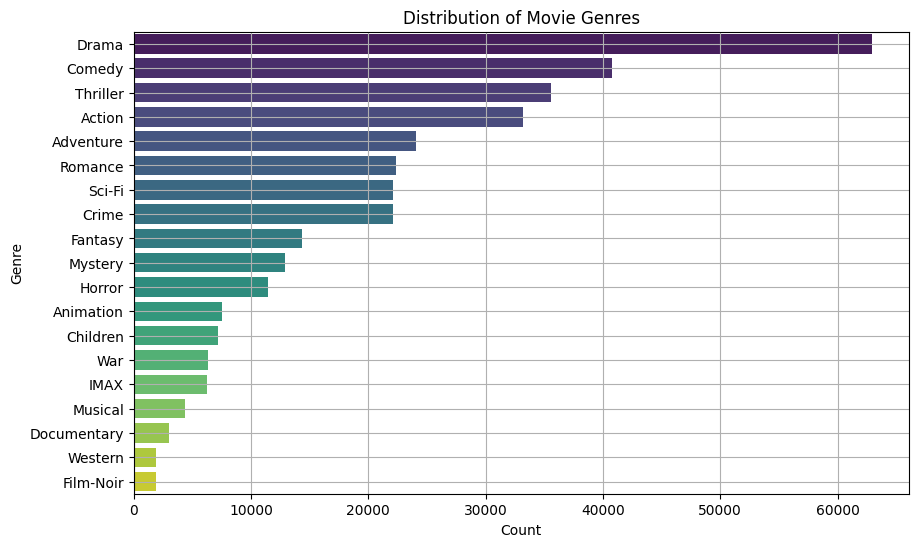

In [76]:
# visualize genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

Most popular movie genre is Drama. Comedy, Thriller, Action is also popular. Film-Noir, Western and  Musical have less audience.

In [77]:
# check NaN
merged_data.isnull().sum()

userId          0
movieId         0
title           0
genres          0
director        0
rating          0
timestamp       0
tag             0
genres_split    0
dtype: int64

In [78]:
# convert timestamp to datetime format
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])

# extract year and month
merged_data['year'] = merged_data['timestamp'].dt.year
merged_data['month'] = merged_data['timestamp'].dt.month

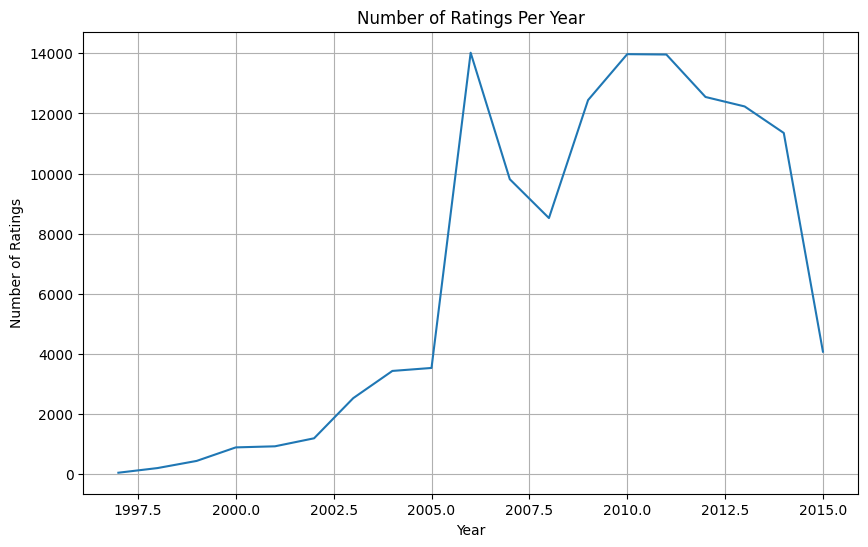

In [79]:
# calculate ratings based on year
ratings_per_year = merged_data.groupby('year').size()

# visualize
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_year.index, ratings_per_year.values)
plt.title('Number of Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

There is a sharp increase in the number of ratings between 2005 and 2010, followed by a significant drop after 2011. Such fluctuations may be related to specific events or trends in the dataset, or to changes in the movie recommendation system and user behavior.

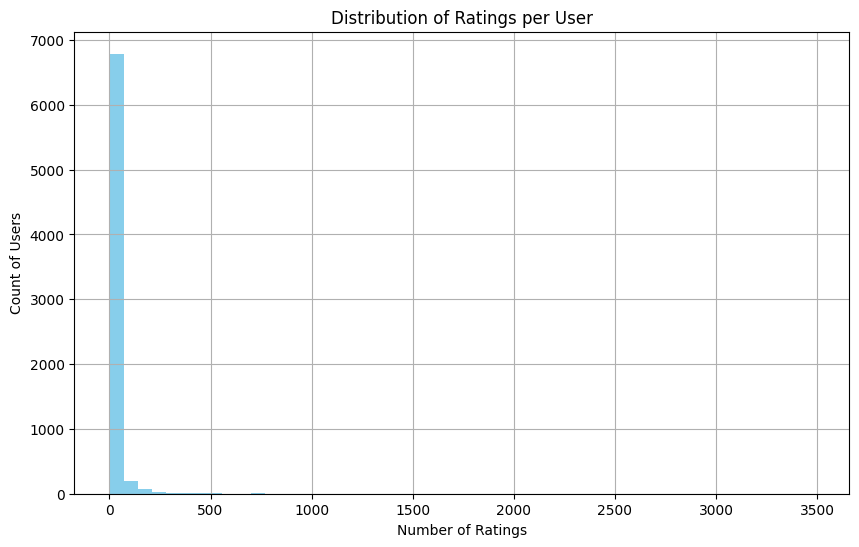

In [80]:
# count the number of ratings for each user 
user_rating_counts = merged_data.groupby('userId').size()

# visualize Distribution of Ratings per User
plt.figure(figsize=(10, 6))
plt.hist(user_rating_counts, bins=50, color='skyblue')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.grid(True)
plt.show()

This is a typical long-tail distribution, where most users have a low number of ratings (less than 100), while a few active users have a large number of ratings.

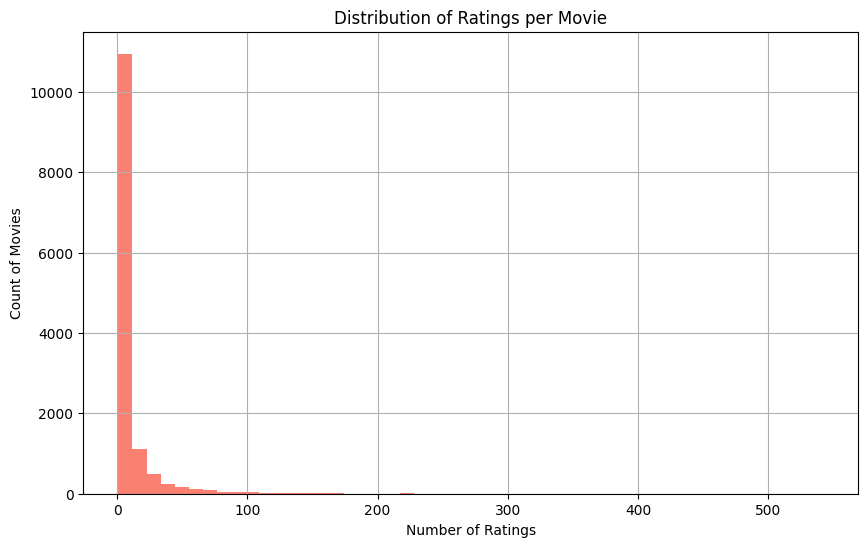

In [81]:
# Count the number of ratings for each movie
movie_rating_counts = merged_data.groupby('movieId').size()

# visualize 'Distribution of Ratings per Movie
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_counts, bins=50, color='salmon')
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.grid(True)
plt.show()

This is also a typical long-tail distribution, where most movies have very few ratings, while a few movies have a very large number of ratings.

In [82]:
# Computing the sparsity of the rating matrix
total_possible_ratings = merged_data['userId'].nunique() * merged_data['movieId'].nunique()
actual_ratings = len(merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9987


The sparsity of the rating matrix is 0.9987, which means that 99.87% of user-movie pairs have no ratings, and only 0.13% of user-movie pairs have rating data. This shows that the dataset is very sparse, with relatively few ratings, and most users have not rated most movies.

In [83]:
# Filter out users who have rated less than 20 times
active_users = user_rating_counts[user_rating_counts >= 20].index
final_merged_data = merged_data[merged_data['userId'].isin(active_users)]

# Filter out movies with less than 50 ratings
popular_movies = movie_rating_counts[movie_rating_counts >= 50].index
final_merged_data = final_merged_data[merged_data['movieId'].isin(popular_movies)]

In [84]:
# Computing the sparsity of the rating matrix again
total_possible_ratings = final_merged_data['userId'].nunique() * final_merged_data['movieId'].nunique()
actual_ratings = len(final_merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9333


Sparsity got improved.

In [85]:
# LabelEncoder for userId 
user_encoder = LabelEncoder()
final_merged_data['userId_encoded'] = user_encoder.fit_transform(final_merged_data['userId'])

# LabelEncoder for movieId:
movie_encoder = LabelEncoder()
final_merged_data['movieId_encoded'] = movie_encoder.fit_transform(final_merged_data['movieId'])

# check data after labelencoding
final_merged_data[['userId', 'userId_encoded', 'movieId', 'movieId_encoded']].head()

,userId,userId_encoded,movieId,movieId_encoded
22,129,0,2706,191
23,129,0,3556,219
26,129,0,4878,247
29,129,0,8641,323
38,129,0,80549,478


In [86]:
# Start the timer
start_time = time.time()

# Define the rating scale and prepare the dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(final_merged_data[['userId_encoded', 'movieId_encoded', 'rating']], reader)

# Define the parameter grid for SVD
param_grid = {
    'n_factors': [50, 100],  # Reduce the number of factors
    'n_epochs': [20, 30],    # Reduce the number of epochs
    'lr_all': [0.005],       # Fix the learning rate to a single value
    'reg_all': [0.02]        # Fix the regularization parameter to a single value
}

# Perform GridSearchCV for parameter tuning (using Surprise's GridSearchCV)
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Fit GridSearchCV on the dataset
grid_search.fit(data)

# Output the best parameters based on RMSE
print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best parameters for SVD model:", grid_search.best_params['rmse'])

# Train the final model with the best parameters
best_svd = grid_search.best_estimator['rmse']
trainset = data.build_full_trainset()
best_svd.fit(trainset)

# Perform predictions on the test set (train/test split is done inside the GridSearchCV)
testset = trainset.build_anti_testset()
predictions = best_svd.test(testset)
# Evaluate the model performance
accuracy.rmse(predictions)
accuracy.mae(predictions)

# End the timer
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

Best RMSE score: 0.8041687643335744
Best parameters for SVD model: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 0.4915
MAE:  0.3796
Total execution time: 5.26 seconds


The RMSE and MAE results show that the prediction error of the model is within a reasonable range, indicating that the performance of the model is good.

In [87]:
def get_user_based_recommendations(user_id, final_merged_data, svd_model, n_recommendations=5):
    """Generate movie recommendations for a specific user based on the SVD model."""
    
    # Build a dictionary of movie IDs and movie titles in advance to optimize search efficiency
    movie_id_to_title = dict(zip(final_merged_data['movieId_encoded'], final_merged_data['title']))
    
    # Get movies that the user has rated
    user_rated_movies = final_merged_data[final_merged_data['userId_encoded'] == user_id]['movieId_encoded'].values
    all_movies = final_merged_data['movieId_encoded'].unique()
    
    # Filter out movies that users have not rated
    unrated_movies = [movie for movie in all_movies if movie not in user_rated_movies]
    
    # Use SVD model to predict ratings and rank based on ratings
    movie_scores = []
    for movie_id in unrated_movies:
        prediction = svd_model.predict(user_id, movie_id)  
        movie_scores.append((movie_id, prediction.est))  
    
    # sort movies based on predicted scores
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)
    
    # Get the IDs of the first n recommended movies
    top_movie_ids = [movie_id for movie_id, score in movie_scores[:n_recommendations]]
    
    # Return movie title based on movie ID
    recommendations = [movie_id_to_title[movie_id] for movie_id in top_movie_ids]
    
    return recommendations
result = get_user_based_recommendations(user_id=100, final_merged_data=final_merged_data, svd_model=best_svd)
result

['Amelie (2001)',
 'Seven Samurai (1954)',
 'Fight Club (1999)',
 'The Lives of Others (2006)',
 'Unforgiven (1992)']

In [88]:
# use MultiLabelBinarizer to One-Hot encode genres

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(merged_data['genres_split'])

# convert the result of One-Hot to DataFrame and add it to the original dataset and ensure the indices match
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=merged_data.index)
merged_data = pd.concat([merged_data, genres_encoded_df], axis=1)

# delete the original genres column and genres_split coloumn
merged_data.drop(['genres', 'genres_split'], axis=1, inplace=True)
merged_data.head()

,userId,movieId,title,director,rating,timestamp,tag,year,month,(no genres listed),...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,65,27866,In My Father's Den (2004),unknown,4.0,2011-05-09 16:05:59,New Zealand,2011,5,0,...,0,0,0,0,0,0,0,0,0,0
1,65,48082,The Science of Sleep (2006),unknown,4.5,2011-05-09 16:26:19,"surreal, unusual",2011,5,0,...,0,0,0,0,0,1,0,0,0,0
2,65,58652,CJ7 (2008),unknown,5.0,2011-05-09 16:09:31,"cute, emotional, girls who play boys, Stephen ...",2011,5,0,...,0,0,0,0,0,0,1,0,0,0
3,96,106696,Frozen (2013),unknown,3.5,2014-03-29 12:48:07,"animation, beautiful, characters, Disney, femi...",2014,3,0,...,0,0,0,1,0,1,0,0,0,0
4,121,778,Trainspotting (1996),Danny Boyle,4.0,2011-03-23 04:00:30,"dark comedy, drugs, Nudity (Full Frontal - Not...",2011,3,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
def recommend_movies_based_on_genres(movie_title, merged_data, n_recommendations=10):
    """
    Recommends movies based on genres similarity using cosine similarity, searched by movie title.

    Parameters:
    movie_title (str): The title of the movie for which to recommend similar movies.
    merged_data (DataFrame): The DataFrame containing the merged movie data with one-hot encoded genres.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    List of tuples with recommended movie titles and their corresponding similarity scores.
    """
    
    # Find the closest matching movie title and its corresponding movieId
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Also convert the input to lowercase
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    
    movie_id = merged_data[merged_data['title'] == original_matched_title]['movieId'].values[0]
        
    # Select numeric columns (assumed to be one-hot encoded genres)
    genre_columns = merged_data.select_dtypes(include=[np.number]).columns.tolist()
    
    # Ensure the movie_id exists in the dataset
    if movie_id not in merged_data['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found in the dataset.")
    
    # Get the index and vector of the matched movie
    movie_idx = merged_data[merged_data['movieId'] == movie_id].index[0]
    movie_vector = merged_data.loc[movie_idx, genre_columns].values.reshape(1, -1)
    
    # Compute cosine similarity between the target movie and all others
    similarity_scores = cosine_similarity(movie_vector, merged_data[genre_columns].values).flatten()
    
    # Get indices of the most similar movies (excluding itself)
    similar_indices = similarity_scores.argsort()[::-1][1:n_recommendations+1]
    
    # Collect recommended movies with scores
    recommended_movies = []
    seen_titles = set()  # Track already recommended titles
    for idx in similar_indices:
        movie_title = merged_data.iloc[idx]['title']
        similarity_score = similarity_scores[idx]  # Get the similarity score
        if movie_title not in seen_titles:
            seen_titles.add(movie_title)
            recommended_movies.append((movie_title, similarity_score))  # Append as a tuple (title, score)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break   
            
    # Filter out the matched movie itself from recommendations
    filtered_recommendations = [(title, score) for title, score in recommended_movies if title != original_matched_title]
    
    return filtered_recommendations[:n_recommendations]  # Return movie titles with similarity scores

# Test the function 
recommended_movies = recommend_movies_based_on_genres('love', merged_data)
recommended_movies

[('Darkon (2006)', 0.9999999698535511),
 ('Now You See Me (2013)', 0.9999998868345709),
 ('20 Feet from Stardom (2013)', 0.999999828122739),
 ('Interstellar (2014)', 0.9999995387764619),
 ('Only Lovers Left Alive (2013)', 0.9999995305408148),
 ('The Amazing Spider-Man 2 (2014)', 0.9999994892310935),
 ('The Raid 2: Berandal (2014)', 0.9999994839064545),
 ('Jean-Michel Basquiat: The Radiant Child (2010)', 0.9999992681178925),
 ('Looper (2012)', 0.9999988890099458),
 ('Django Unchained (2012)', 0.99999875993887)]

In [90]:
# define stopwords
stop_words = set(stopwords.words('english'))

def preprocess_tags(text):
    # convert input to string
    if not isinstance(text, str):
        text = str(text)
    
    tags = text.split(',') 

    # Clean and process each tag
    cleaned_tags = []
    for tag in tags:
        tag = tag.strip()  # Remove leading/trailing spaces
        tag = tag.lower()  # Convert to lowercase
        tag = re.sub(r'[^\w\s]', '', tag)  # Remove special characters and punctuation
        tag = ' '.join([word for word in tag.split() if word not in stop_words])  # Remove stopwords

        # Append the cleaned tag to the list if it's not empty
        if tag:
            cleaned_tags.append(tag)

    # Remove duplicates by converting to a set
    unique_tags = list(set(cleaned_tags))
    cleaned_text = ', '.join(unique_tags)

    return cleaned_text

# Apply the function to 'tag' column
merged_data['tags_processed'] = merged_data['tag'].fillna('').apply(preprocess_tags)
merged_data['tags_processed'].head()

0                                          new zealand
1                                     unusual, surreal
2       stephen chow, emotional, girls play boys, cute
3    characters, ice, voice acting, feminist, anima...
4    drugs, nudity full frontal, dark comedy, nudit...
Name: tags_processed, dtype: object

In [91]:
# use TF-IDF to vectorize `tags` colomn 
tfidf = TfidfVectorizer(max_features=1000)
tags_tfidf_matrix = tfidf.fit_transform(merged_data['tags_processed'])

In [92]:
def recommend_movies_based_on_tags(movie_title, merged_data, tags_tfidf_matrix, n_recommendations=10):
    """
    Recommends movies based on tags similarity using cosine similarity, searched by movie title.

    Parameters:
    movie_title (str): The title of the movie to search.
    merged_data (DataFrame): The DataFrame containing the movie data with TF-IDF vectorized tags.
    tags_tfidf_matrix (ndarray): The TF-IDF matrix representing the tags of the movies.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of tuples with recommended movie titles and their corresponding similarity scores.
    """
    
    # Find the closest matching movie title and its corresponding movieId
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find the closest match
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    
    # Find the corresponding movie ID and index
    movie_id = merged_data[merged_data['title'] == original_matched_title]['movieId'].values[0]
    
    # Ensure the movie ID exists in the dataset
    if movie_id not in merged_data['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found.")
    
    # Get the index and vector of the target movie
    movie_idx = merged_data[merged_data['movieId'] == movie_id].index[0]
    movie_vector = tags_tfidf_matrix[movie_idx].reshape(1, -1)
    
    # Compute cosine similarity between the target movie and all others
    similarity_scores = cosine_similarity(movie_vector, tags_tfidf_matrix).flatten()
    
    # Get indices of top similar movies (excluding itself), requesting more to handle duplicates
    similar_indices = similarity_scores.argsort()[::-1][1:(n_recommendations * 5)]  # Request more in case of duplicates
    
    # Collect recommended movie titles with similarity scores
    recommended_movies = []
    seen_titles = set()  # To keep track of unique movie titles
    
    for idx in similar_indices:
        movie_title = merged_data.iloc[idx]['title']
        similarity_score = similarity_scores[idx]  # Get the similarity score
        
        # Only add unique movie titles (skip duplicates and the original movie)
        if movie_title not in seen_titles and movie_title != original_matched_title:
            seen_titles.add(movie_title)
            recommended_movies.append((movie_title, similarity_score))  # Append as a tuple (title, score)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    # Ensure we return exactly the requested number of recommendations
    return recommended_movies[:n_recommendations]

# Test the function 
recommended_movies = recommend_movies_based_on_tags('love', merged_data, tags_tfidf_matrix)
recommended_movies

[('Guardians of the Galaxy (2014)', 1.0),
 ('Interstellar (2014)', 1.0),
 ('The Chronicles of Riddick (2004)', 1.0),
 ('Aliens (1986)', 1.0),
 ('Lost in Space (1998)', 1.0),
 ('Sunshine (2007)', 1.0),
 ('Apollo 13 (1995)', 1.0),
 ('Star Trek V: The Final Frontier (1989)', 1.0),
 ('Gagarin: First in Space (2013)', 1.0),
 ('Gravity (2013)', 1.0)]

In [93]:
def recommend_movies_by_director(movie_title, merged_data, n_recommendations=5):
    """
    Recommends movies by the same director, based on the input movie title.

    Parameters:
    movie_title (str): The title of the movie to search.
    merged_data (DataFrame): The DataFrame containing the movie data, including director information.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of recommended movies by the same director, or a message if no director is found.
    """
    
    # Find the movie title and get the corresponding director
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find the closest match
    
    if not closest_matches:
        return []

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title and corresponding director
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    director = merged_data[merged_data['title'] == original_matched_title]['director'].values[0]
    
    # Check if the director is found
    if director == 'unknown':
        return []

    # Recommend movies by the same director
    movies_by_director = merged_data[merged_data['director'] == director]
    
    # Exclude the original movie from recommendations
    movies_by_director = movies_by_director[movies_by_director['title'] != original_matched_title]
    
    # Collect unique recommendations
    recommended_movies = []
    seen_titles = set()  # To keep track of unique movie titles

    for title in movies_by_director['title']:
        if title not in seen_titles:
            seen_titles.add(title)
            recommended_movies.append(title)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    return recommended_movies[:n_recommendations]

# test the function
recommended_movies = recommend_movies_by_director('black swan', merged_data, n_recommendations=5)
recommended_movies

['Requiem for a Dream (2000)', 'The Wrestler (2008)']

In [94]:
def combined_recommendation(movie_title_or_id, merged_data, tags_tfidf_matrix, genre_weight=0.5, n_recommendations=5):
    """
    Combines recommendations based on genres, tags, and directors if applicable.
    
    Parameters:
    movie_title_or_id (str or int): The title of the movie or user ID to search.
    merged_data (DataFrame): The DataFrame containing the movie data, including genres, tags, and director information.
    tags_tfidf_matrix (ndarray): The TF-IDF matrix representing the tags of the movies.
    genre_weight (float): The weight to apply to genre-based recommendations.
    tag_weight (float): The weight to apply to tag-based recommendations.
    n_recommendations (int): The number of similar movie recommendations to return (default is 5).
    
    Returns:
    A list of recommended movie titles.
    """
    
    tag_weight = 1 - genre_weight
    
    # Initialize variables to store recommendations
    genre_similar_movies = []
    tag_similar_movies = []
    director_recommendations = []

    # Get genre-based and tag-based recommendations
    genre_similar_movies = recommend_movies_based_on_genres(movie_title_or_id, merged_data, 10)  # Get 10 from genre function
    tag_similar_movies = recommend_movies_based_on_tags(movie_title_or_id, merged_data, tags_tfidf_matrix, 10)  # Get 10 from tag function

    # Get director-based recommendations if available (list of movie titles)
    director_recommendations = recommend_movies_by_director(movie_title_or_id, merged_data, n_recommendations=2)

    # Combine recommendations (starting with director-based if available)
    combined_recommendations = []

    # Prioritize director recommendations (1 or 2 movies)
    num_director_movies = min(2, len(director_recommendations))  # Take 1 or 2 movies from director recommendations
    combined_recommendations.extend(director_recommendations[:num_director_movies])

    # Calculate the remaining number of movies to pick from genre and tag recommendations
    remaining_slots = n_recommendations - len(combined_recommendations)  # Remaining slots after picking director movies
    
    # Calculate how many movies to take from genre and tag recommendations based on the weights
    num_genre_movies = math.ceil(genre_weight * remaining_slots)  # Number of movies to take from genre recommendations
    num_tag_movies = remaining_slots - num_genre_movies  # The rest will be from tag recommendations

    # Add movies from genre and tag recommendations (without duplicates)
    genre_movies_to_add = [movie for movie, _ in genre_similar_movies if movie.lower() not in [m.lower() for m in combined_recommendations]][:num_genre_movies]
    combined_recommendations.extend(genre_movies_to_add)

    tag_movies_to_add = [movie for movie, _ in tag_similar_movies if movie.lower() not in [m.lower() for m in combined_recommendations]][:num_tag_movies]
    combined_recommendations.extend(tag_movies_to_add)

    # Return only the movie titles, ensuring there are exactly `n_recommendations`
    return combined_recommendations[:n_recommendations]

# Example usage:
result = combined_recommendation('love', merged_data, tags_tfidf_matrix, genre_weight=0.9, n_recommendations=5)
result

['Darkon (2006)',
 'Now You See Me (2013)',
 '20 Feet from Stardom (2013)',
 'Interstellar (2014)',
 'Only Lovers Left Alive (2013)']

In [95]:
def recommend_interface(user_input, genre_weight=0.5):
    try:
        # Try to parse the input as a user ID
        user_id = int(user_input)
        # Use SVD-based recommendation for user ID
        recommendations = get_user_based_recommendations(user_id, final_merged_data, best_svd, n_recommendations=5)
        return "\n".join(recommendations)
    except ValueError:
        # When input is a movie title, use combined recommendation
        movie_title = user_input
        try:
            # Call the combined recommendation function
            recommendations = combined_recommendation(movie_title, merged_data, tags_tfidf_matrix, genre_weight=genre_weight, n_recommendations=5)
            
            if recommendations:
                # Return only the movie titles, no need to return the scores
                return "\n".join(recommendations)
            else:
                return "Oops, no movie found with a title similar to '{}'.".format(movie_title)
        except ValueError:
            return "Oops, no movie found with a title similar to '{}'.".format(movie_title)

# Create Gradio interface with a slider to adjust genre and tag weights
interface = gr.Interface(
    fn=recommend_interface,
    inputs=[
        gr.Textbox(label="Enter User ID or Movie Title"),
        gr.Slider(
            label="Weight:",
            minimum=0, 
            maximum=1, 
            value=0.5, 
            step=0.1,
            info="Vibe to the left, genre to the right:)"
        )
    ],
    outputs=gr.Textbox(label="Recommended Movies"),
    title="Charlotte's Movie Recommendation System 1.0",
    description="Enter a User ID for personalized recommendations, or a movie title for content-based recommendations. Adjust the slider for more tag-based or genre-based results."
)

# Launch the Gradio interface
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://410d42344f546bca05.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


############ somethign about cons on version 1#############

In [96]:
# Neural Network First Attempt

In [97]:
# check current dataset
merged_data_copy.head()

,userId,movieId,title,genres,director,rating,timestamp,tag
0,65,27866,In My Father's Den (2004),Drama,unknown,4.0,2011-05-09 16:05:59,New Zealand
1,65,48082,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unknown,4.5,2011-05-09 16:26:19,"surreal, unusual"
2,65,58652,CJ7 (2008),Children|Comedy|Sci-Fi,unknown,5.0,2011-05-09 16:09:31,"cute, emotional, girls who play boys, Stephen ..."
3,96,106696,Frozen (2013),Adventure|Animation|Comedy|Fantasy|Musical|Rom...,unknown,3.5,2014-03-29 12:48:07,"animation, beautiful, characters, Disney, femi..."
4,121,778,Trainspotting (1996),Comedy|Crime|Drama,Danny Boyle,4.0,2011-03-23 04:00:30,"dark comedy, drugs, Nudity (Full Frontal - Not..."


In [98]:
#data preprocessing

#First, make sure that each movie's data characteristics (user ID, movie ID, genre, director, and tags) are encoded.

# use Label Encoding on userId and movieId 
user_encoder = LabelEncoder()
merged_data_copy['userId_encoded'] = user_encoder.fit_transform(merged_data_copy['userId'])

movie_encoder = LabelEncoder()
merged_data_copy['movieId_encoded'] = movie_encoder.fit_transform(merged_data_copy['movieId'])

# Label Encoding on director column
director_encoder = LabelEncoder()
merged_data_copy['director_encoded'] = director_encoder.fit_transform(merged_data_copy['director'])

# use MultiLabelBinarizer to One-Hot encode genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(merged_data_copy['genres'].str.split('|'))

# Use TfidfVectorizer to TF-IDF encode tags
tfidf = TfidfVectorizer(max_features=1000)
tags_tfidf_matrix = tfidf.fit_transform(merged_data_copy['tag'].fillna(''))

# Prepare training data
X_train = [
    merged_data_copy['userId_encoded'].values, 
    merged_data_copy['movieId_encoded'].values, 
    genres_encoded, 
    merged_data_copy['director_encoded'].values, 
    tags_tfidf_matrix.toarray()
]
y_train = merged_data_copy['rating'].values

In [99]:
# Build a neural network model

# Use the Embedding layer to encode userId and movieId and the fully connected layer for rating prediction.
# Get the maximum user and movie ID of the data
num_users = merged_data_copy['userId_encoded'].nunique()
num_movies = merged_data_copy['movieId_encoded'].nunique()
num_directors = merged_data_copy['director_encoded'].nunique()

# Define embedding size
embedding_size = 50

# User input layer
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
user_vector = Flatten(name='user_vector')(user_embedding)

# Movie input layer
movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)
movie_vector = Flatten(name='movie_vector')(movie_embedding)

# Genre input layer - data encoded using one-hot
genre_input = Input(shape=(genres_encoded.shape[1],), name='genre_input')

# Director input layer - LabelEncoder the director
director_input = Input(shape=(1,), name='director_input')
director_embedding = Embedding(input_dim=num_directors, output_dim=embedding_size, name='director_embedding')(director_input)
director_vector = Flatten(name='director_vector')(director_embedding)

# tag input layer - using TF-IDF matrix
tag_input = Input(shape=(tags_tfidf_matrix.shape[1],), name='tag_input')

# Combine all features
merged = Concatenate(name='merged_layer')([user_vector, movie_vector, genre_input, director_vector, tag_input])

# Add dense layer
dense_1 = Dense(128, activation='relu')(merged)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)

# Output layer
output = Dense(1, activation='linear', name='output')(dropout_2)

# build model
model = Model(inputs=[user_input, movie_input, genre_input, director_input, tag_input], outputs=output)

# compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# chech summary
model.summary()

I0000 00:00:1727644466.123087  269480 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │    357,950 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │    669,800 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_embedding  │ (None, 1, 50)     │     17,450 │ director_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_vector         │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_vector        │ (None, 50)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_vector     │ (None, 50)        │          0 │ director_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tag_input           │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_layer        │ (None, 1170)      │          0 │ user_vector[0][0… │
│ (Concatenate)       │                   │            │ movie_vector[0][… │
│                     │                   │            │ genre_input[0][0… │
│                     │                   │            │ director_vector[… │
│                     │                   │            │ tag_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    149,888 │ merged_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,203,409 (4.59 MB)

 Trainable params: 1,203,409 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

Final Training Loss: 0.4129, Final Training MAE: 0.4564
Final Validation Loss: 0.9764, Final Validation MAE: 0.7625


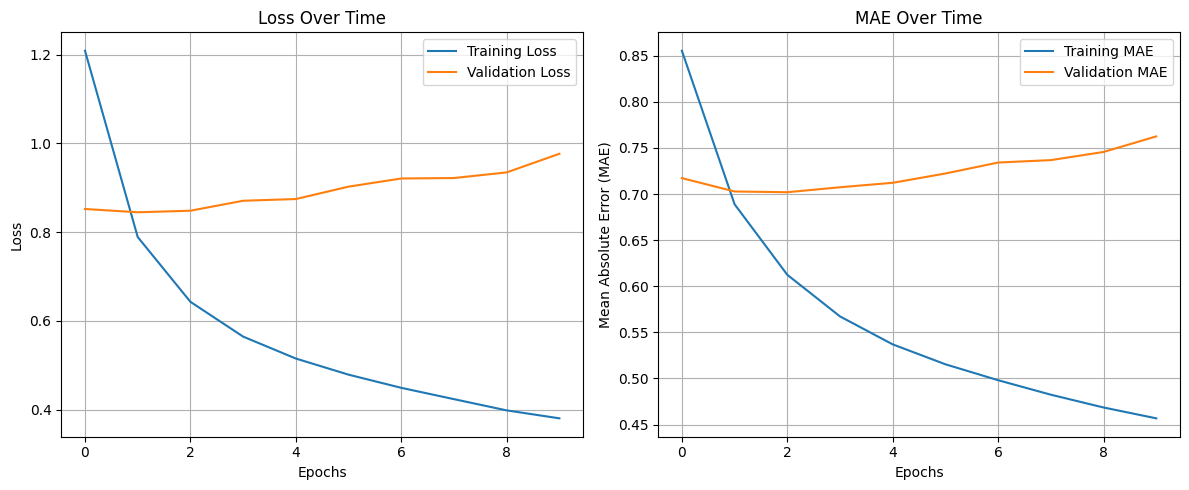

In [100]:
# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# show results
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss = history.history['val_loss'][-1]
val_mae = history.history['val_mae'][-1]
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")

# visualize model loss and MAE
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # plot training and validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_history(history)

The model shows signs of overfitting. Training loss and MAE decrease, but validation loss and MAE fluctuate, indicating poor generalization.

Overfitting improves a bit but loss and mae is increasing.

Final Training Loss: 0.5119, Final Training MAE: 0.5333
Final Validation Loss: 0.5119, Final Validation MAE: 0.5333


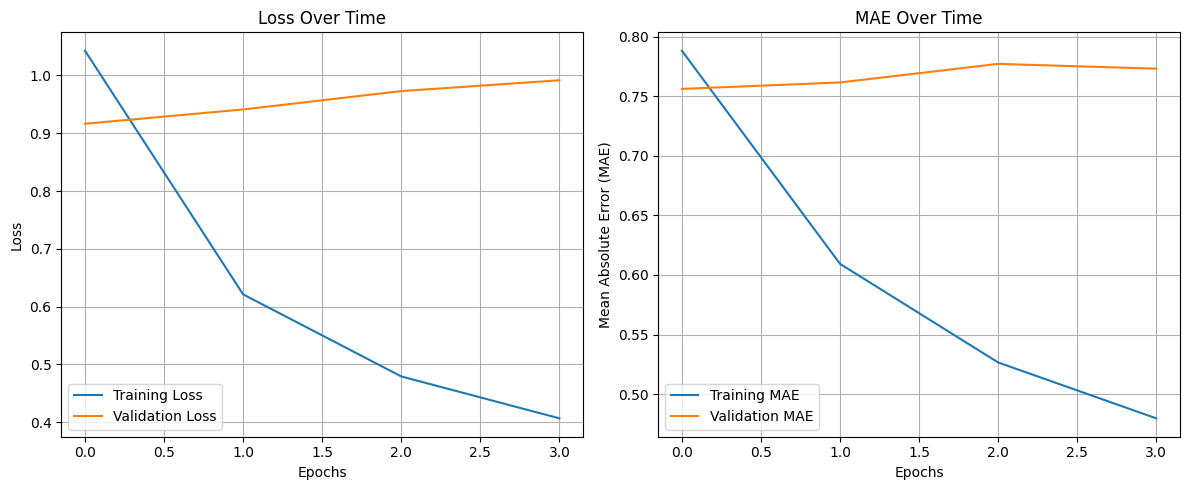

In [101]:
# repeat steps above but add earlystopping
dense_1 = Dense(128, activation='relu')(merged)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model = Model(inputs=[user_input, movie_input, genre_input, director_input, tag_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # add earlystopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After adding Early Stopping, the model stopped training early (after about 3 epochs). The training loss and MAE improved steadily, but the validation loss and MAE continue to increase. This indicates that while the model is learning effectively on the training data, it still suffers from overfitting, as the validation performance worsens as training progresses.

Final Training Loss: 0.4762, Final Training MAE: 0.5101
Final Validation Loss: 0.4762, Final Validation MAE: 0.5101


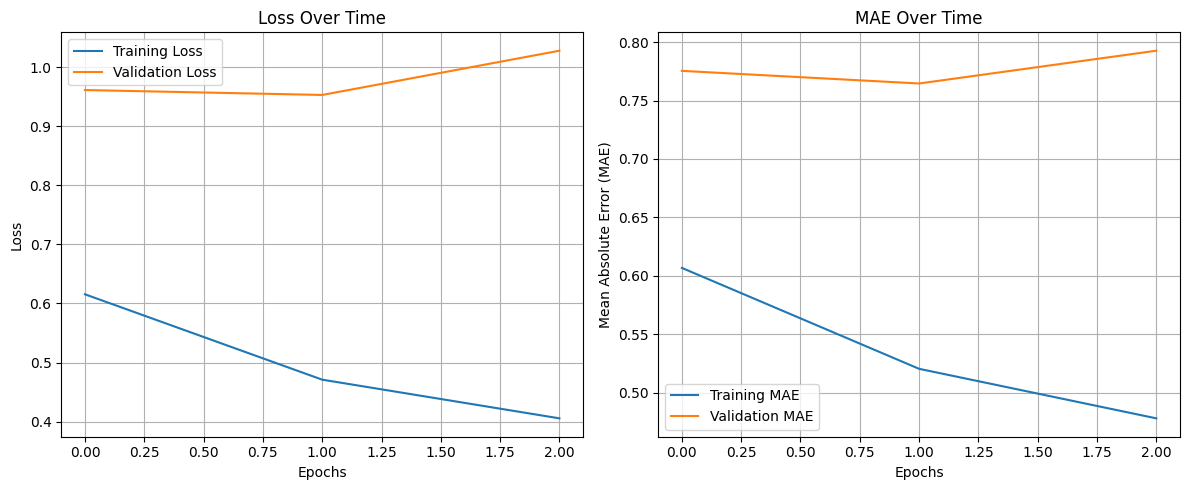

In [102]:
# reduce neurons to reduce overfitting
dense_1 = Dense(64, activation='relu')(merged)  # reduce to 64 neurons
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)  # reduce to 32 neurons
dropout_2 = Dropout(0.5)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After reducing the number of neurons in the model, the loss and MAE of the training set continue to decrease, but the loss and MAE of the validation set have almost no change and remain at a high level from the beginning of training. Although the model performed well on the training set, its performance on the validation set was still not ideal, and there were still signs of overfitting.

Final Training Loss: 0.4492, Final Training MAE: 0.4892
Final Validation Loss: 0.4492, Final Validation MAE: 0.4892


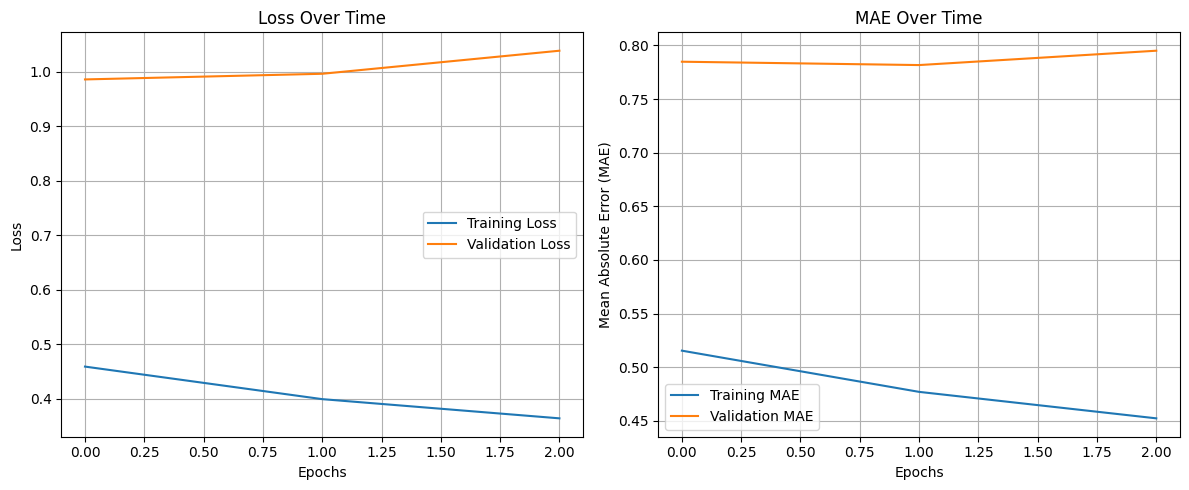

In [103]:
# reduce learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After reducing the learning rate, the loss and MAE of the training set further decreased, but the loss and MAE of the validation set hardly improved and remained at a high level from the beginning, and the performance of the validation set did not follow the improvement of the training set. This still shows that the model's generalization ability on the validation set is not strong, and the loss and MAE of the validation set have not declined from the beginning.

Final Training Loss: 0.4279, Final Training MAE: 0.4715
Final Validation Loss: 0.4279, Final Validation MAE: 0.4715


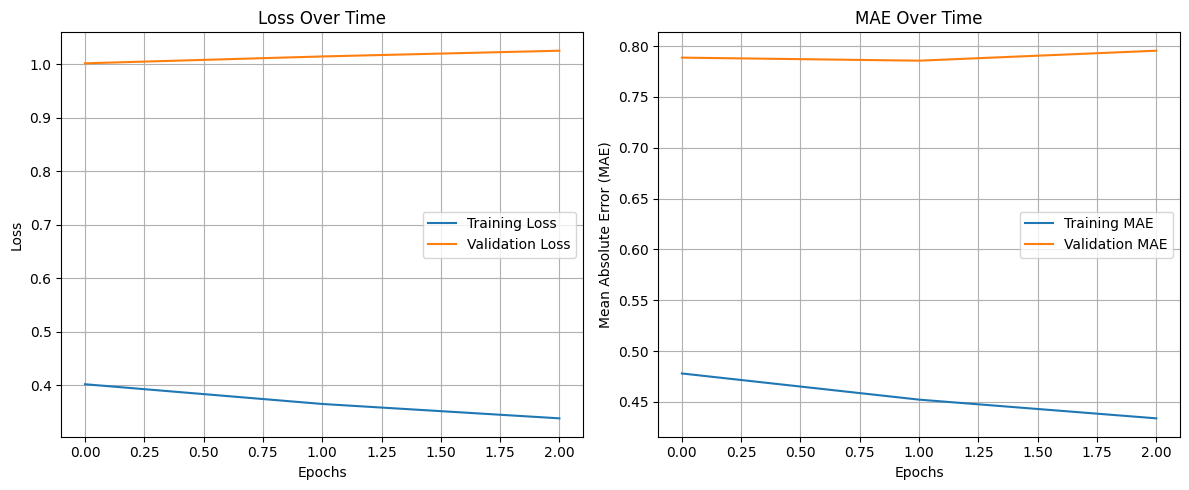

In [104]:
# add regularization
dense_1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After adding L2 regularization, the training loss and MAE decreased again, but the validation set loss and MAE remained the same and remained at a high level from the beginning of training. This shows that L2 regularization plays a certain role in the training set, but fails to improve the generalization ability on the verification set, and the model still overfits on the verification set.

Final Training Loss: 0.4120, Final Training MAE: 0.4530
Final Validation Loss: 0.4120, Final Validation MAE: 0.4530


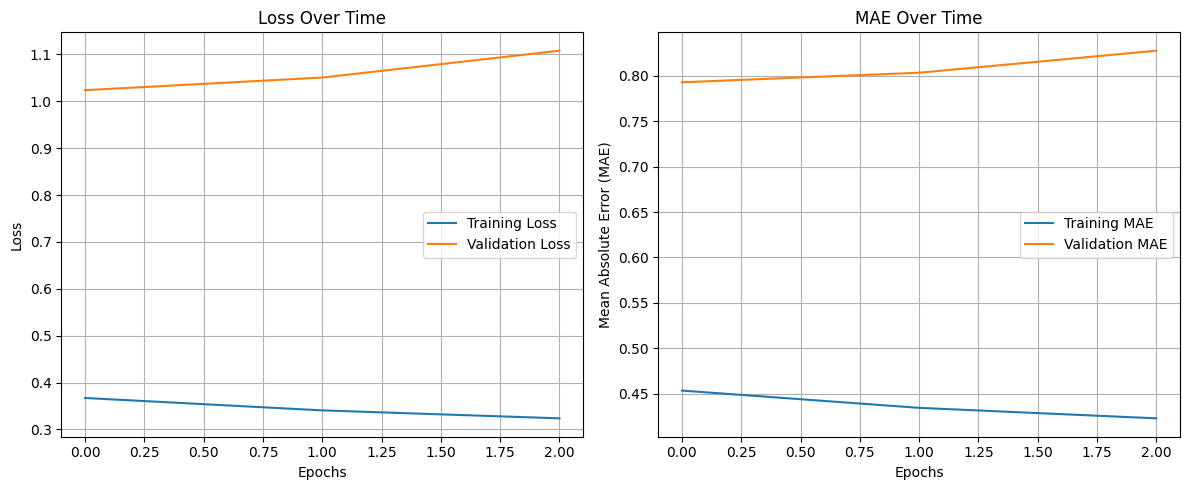

In [105]:
# increase dropout rate
dense_1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged)
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = Dropout(0.6)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After increasing the Dropout ratio, the loss and MAE of the training set decreased slightly, but the loss and MAE of the verification set still did not improve significantly. The loss and MAE of the validation set still remain at a high level, indicating that the model is still significantly overfitting.

Final Training Loss: 0.4100, Final Training MAE: 0.4509
Final Validation Loss: 0.4100, Final Validation MAE: 0.4509


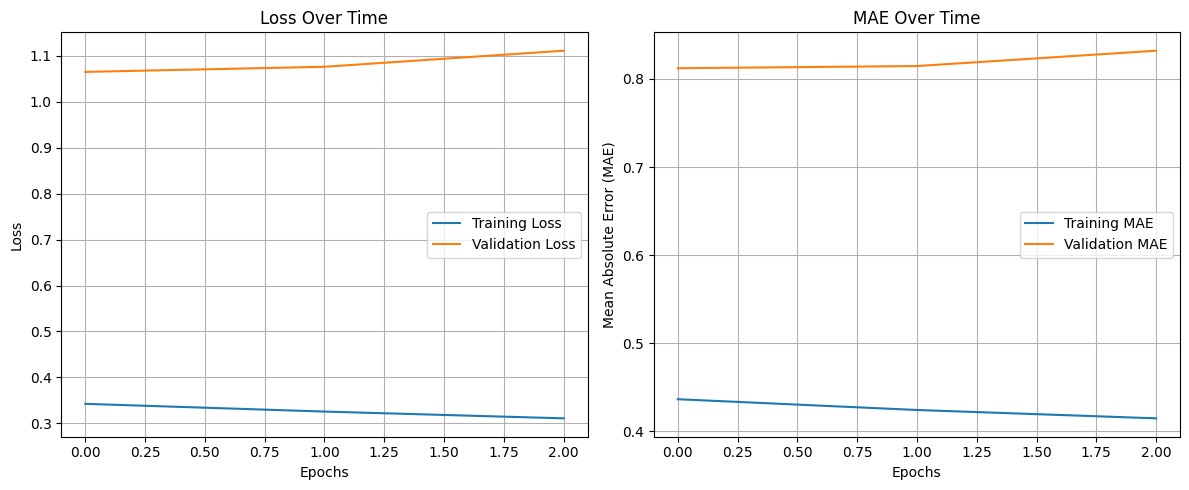

In [106]:
# reduce neurons again
dense_1 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged)
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = Dropout(0.6)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

The results after reducing neurons show that the loss and MAE of the training set continue to decrease, but the loss and MAE of the validation set still remain at a high level. Although the model has become simpler, the performance on the validation set still has not improved, indicating that the model still has the problem of insufficient generalization ability.

Conclusion: This neural network model predicts movie ratings by combining collaborative filtering and content-based features. It uses embedding layers to encode user, movie, and director IDs into dense vectors, while genre information is one-hot encoded and tags are processed using a TF-IDF matrix. 

All input vectors are merged and passed through two dense layers (128 and 64 units) with ReLU activation, and dropout layers (50%) to prevent overfitting. The final output layer produces a single rating prediction. Optimized with the Adam optimizer, the model minimizes mean squared error (MSE) and tracks mean absolute error (MAE) for evaluation.

But after several tuning, the model performance doesn't getting any better.

In [107]:
# Neural Network Second Attempt

In [108]:
merged_data_copy.head()

,userId,movieId,title,genres,director,rating,timestamp,tag,userId_encoded,movieId_encoded,director_encoded
0,65,27866,In My Father's Den (2004),Drama,unknown,4.0,2011-05-09 16:05:59,New Zealand,0,6653,348
1,65,48082,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unknown,4.5,2011-05-09 16:26:19,"surreal, unusual",0,7692,348
2,65,58652,CJ7 (2008),Children|Comedy|Sci-Fi,unknown,5.0,2011-05-09 16:09:31,"cute, emotional, girls who play boys, Stephen ...",0,8453,348
3,96,106696,Frozen (2013),Adventure|Animation|Comedy|Fantasy|Musical|Rom...,unknown,3.5,2014-03-29 12:48:07,"animation, beautiful, characters, Disney, femi...",1,12261,348
4,121,778,Trainspotting (1996),Comedy|Crime|Drama,Danny Boyle,4.0,2011-03-23 04:00:30,"dark comedy, drugs, Nudity (Full Frontal - Not...",2,562,62


Training Loss: 0.7235, Training MAE: 0.6557
Validation Loss: 0.8215, Validation MAE: 0.6986


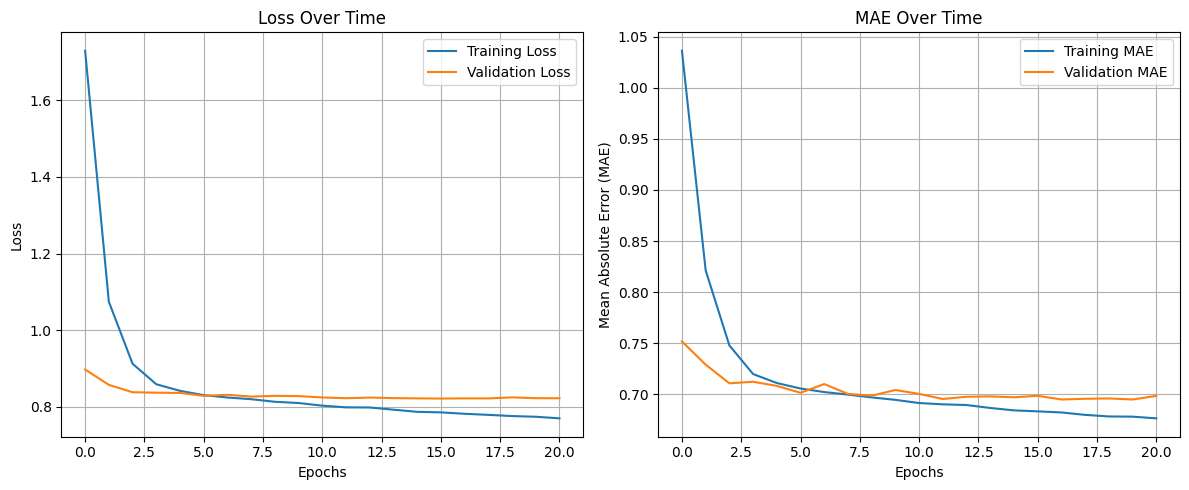

In [109]:
# use neural network handle genres and tags
genre_input = Input(shape=(genres_encoded.shape[1],), name='genre_input')
tag_input = Input(shape=(tags_tfidf_matrix.shape[1],), name='tag_input')

# build the model
merged = Concatenate(name='merged_layer')([genre_input, tag_input])
dense_1 = Dense(64, activation='relu')(merged)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)
nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)

# compile the model
model = Model(inputs=[genre_input, tag_input], outputs=nn_output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Define EarlyStopping to monitor validation loss 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# define target
y = merged_data_copy['rating'].values  

# split genres and tags 
X_train_genre, X_val_genre, X_train_tag, X_val_tag, y_train, y_val = sk_train_test_split(
    genres_encoded,  # genres
    tags_tfidf_matrix.toarray(),  # tags
    y,  
    test_size=0.2,  
    random_state=42)

# check shape to ensure input (debug)
# print(f"X_train_genre shape: {X_train_genre.shape}")
# print(f"X_val_genre shape: {X_val_genre.shape}")
# print(f"X_train_tag shape: {X_train_tag.shape}")
# print(f"X_val_tag shape: {X_val_tag.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_val shape: {y_val.shape}")


# Train the model
history = model.fit(
    [X_train_genre, X_train_tag],  # Inputs
    y_train,  # Target (ratings)
    epochs=50,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=([X_val_genre, X_val_tag], y_val),  # Validation data
    callbacks=[early_stopping],  # EarlyStopping callback
    verbose=0 
)

# Evaluate the model on the training set
train_loss, train_mae = model.evaluate([X_train_genre, X_train_tag], y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")

# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

# Plot history
plot_history(history)

Judging from the performance of the training set, the model is obviously gradually learning more features.
However, the loss on the validation set did not drop as significantly as the training set, which means that although the model performed well on the training set, there was still a large error on the validation set (loss of 0.8189 and MAE of 0.6964) , need further optimization

Training Loss: 0.7396, Training MAE: 0.6602
Validation Loss: 0.8233, Validation MAE: 0.6979


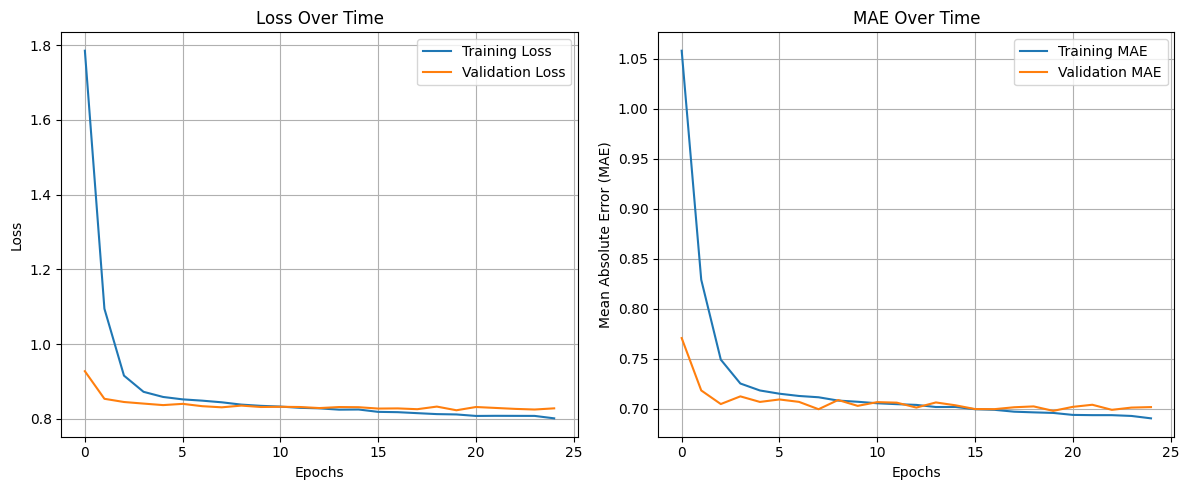

In [110]:
# tune the model(3rd NN)

# repeat the steps above but increase dropout rate
merged = Concatenate(name='merged_layer')([genre_input, tag_input])
dense_1 = Dense(64, activation='relu')(merged)
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.6)(dense_2)
nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)
model = Model(inputs=[genre_input, tag_input], outputs=nn_output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_genre, X_train_tag], 
    y_train,  
    epochs=50, 
    batch_size=32,  # Batch size
    validation_data=([X_val_genre, X_val_tag], y_val),  
    callbacks=[early_stopping],  
    verbose=0 
)
train_loss, train_mae = model.evaluate([X_train_genre, X_train_tag], y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
plot_history(history)

Although the model did not suffer from serious overfitting after adding Dropout, the performance of the validation set did not improve significantly, indicating that simply adding Dropout may not be enough.

Training Loss: 0.7266, Training MAE: 0.6563
Validation Loss: 0.8210, Validation MAE: 0.6978


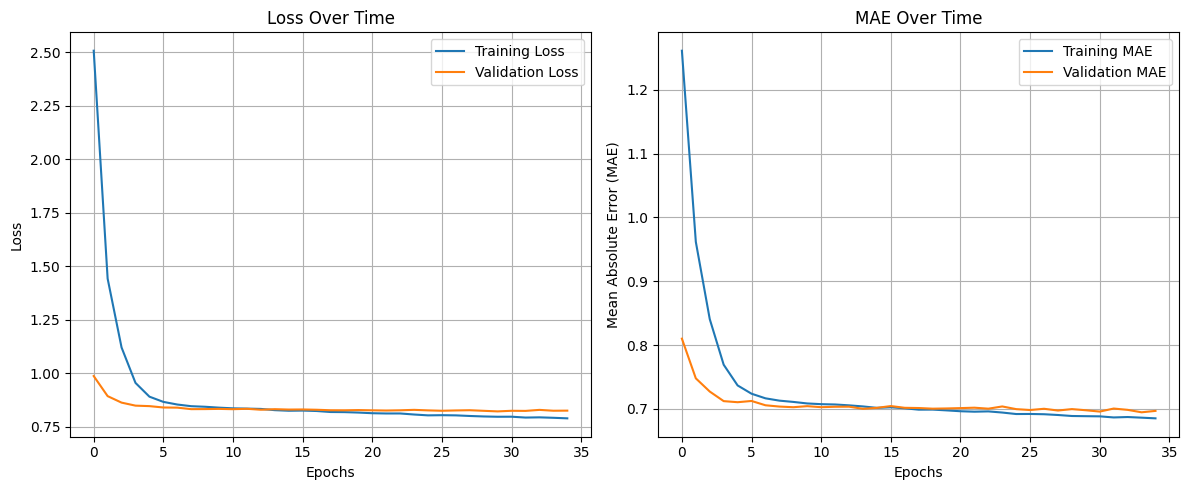

In [111]:
# repeat the steps above but lower learning rate
merged = Concatenate(name='merged_layer')([genre_input, tag_input])
dense_1 = Dense(64, activation='relu')(merged)
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.6)(dense_2)
nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)
model = Model(inputs=[genre_input, tag_input], outputs=nn_output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])# lower lr
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_genre, X_train_tag], 
    y_train,  
    epochs=50, 
    batch_size=32,  
    validation_data=([X_val_genre, X_val_tag], y_val), 
    callbacks=[early_stopping], 
    verbose=0 
)
train_loss, train_mae = model.evaluate([X_train_genre, X_train_tag], y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
plot_history(history)

The loss and MAE of the validation set are almost the same as those of the training set, indicating that the overfitting phenomenon has been reduced and the model's generalization ability on the validation set has been improved.
Although the Loss and MAE of the validation set did not drop significantly, they at least remained in a relatively stable state without obvious overfitting.

Training Loss: 0.7718, Training MAE: 0.6771
Validation Loss: 0.8320, Validation MAE: 0.7029


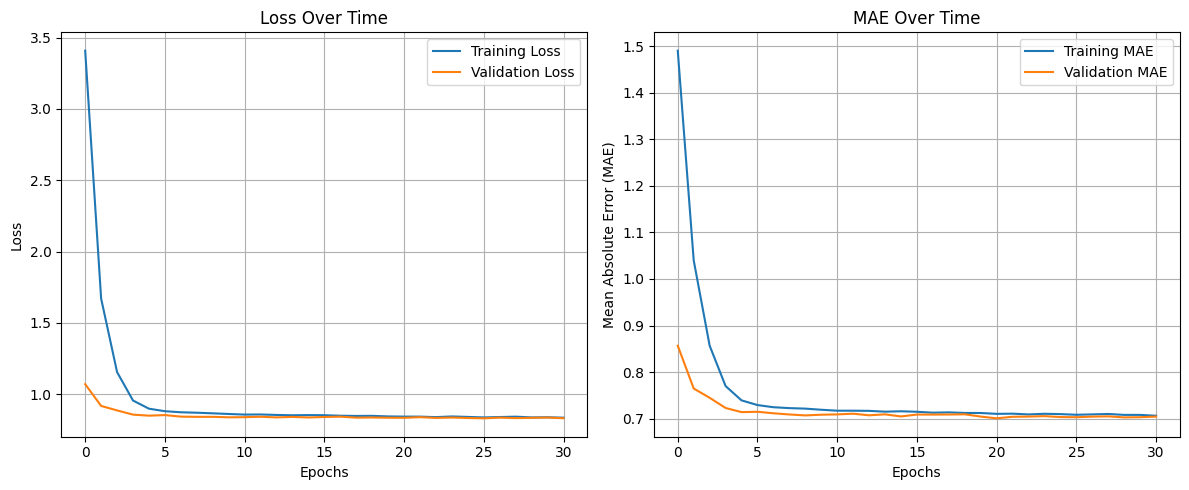

In [112]:
# repeat the steps above but reduce neurons 
merged = Concatenate(name='merged_layer')([genre_input, tag_input])
dense_1 = Dense(32, activation='relu')(merged) # reduce neurons
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(16, activation='relu')(dropout_1) # reduce neurons
dropout_2 = Dropout(0.6)(dense_2)
nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)
model = Model(inputs=[genre_input, tag_input], outputs=nn_output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])# lower lr
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_genre, X_train_tag], 
    y_train,  
    epochs=50, 
    batch_size=32,  
    validation_data=([X_val_genre, X_val_tag], y_val), 
    callbacks=[early_stopping], 
    verbose=0 
)
train_loss, train_mae = model.evaluate([X_train_genre, X_train_tag], y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
plot_history(history)

Since the validation loss and validation MAE are very close to the trained ones, this shows that the model not only fits the training set well, but also performs very stably on the validation set.

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...


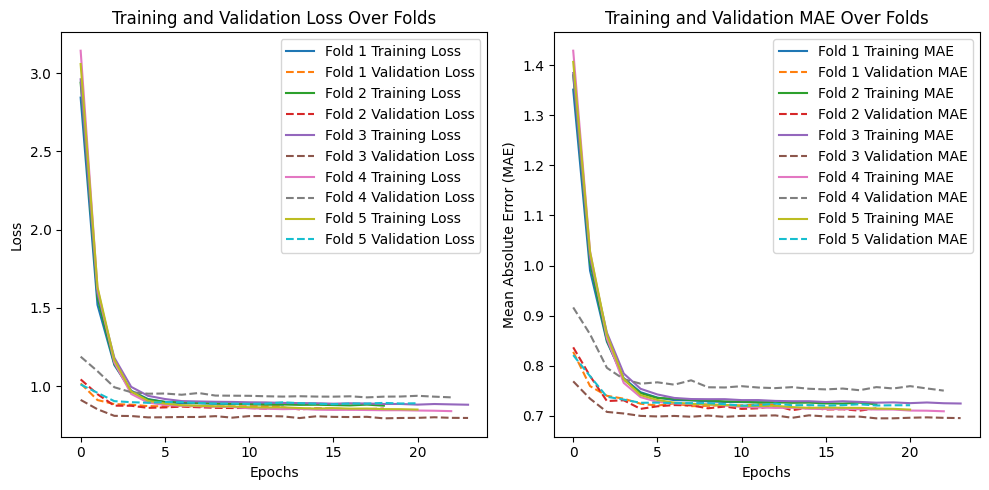

Average Validation Loss: 0.8646085262298584
Average Validation MAE: 0.7195944786071777


In [113]:
# Use KFold to evaluate model performance

# Define KFold with 5 splits
kf = KFold(n_splits=5)

# Lists to store evaluation metrics for each fold
val_losses = []
val_maes = []

# Lists to store loss and MAE history for all folds
train_loss_history = []
val_loss_history = []
train_mae_history = []
val_mae_history = []

# Loop through each fold
fold_no = 1
for train_index, val_index in kf.split(genres_encoded, tags_tfidf_matrix.toarray()):    
    print(f"Training fold {fold_no}...")
    
    # Split data into training and validation sets for this fold
    X_train_genre, X_val_genre = genres_encoded[train_index], genres_encoded[val_index]
    X_train_tag, X_val_tag = tags_tfidf_matrix.toarray()[train_index], tags_tfidf_matrix.toarray()[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Build model for each fold
    genre_input = Input(shape=(X_train_genre.shape[1],), name='genre_input')
    tag_input = Input(shape=(X_train_tag.shape[1],), name='tag_input')

    # Merge the two input branches
    merged = Concatenate(name='merged_layer')([genre_input, tag_input])
    dense_1 = Dense(32, activation='relu')(merged) 
    dropout_1 = Dropout(0.6)(dense_1)
    dense_2 = Dense(16, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.6)(dense_2)
    nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)

    model = Model(inputs=[genre_input, tag_input], outputs=nn_output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model for this fold
    history = model.fit(
        [X_train_genre, X_train_tag], 
        y_train_fold,  
        epochs=50, 
        batch_size=32,  
        validation_data=([X_val_genre, X_val_tag], y_val_fold), 
        callbacks=[early_stopping], 
        verbose=0
    )

    # Evaluate model performance on validation set
    val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val_fold, verbose=0)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    # Store training and validation loss and MAE histories for plotting
    train_loss_history.append(history.history['loss'])
    val_loss_history.append(history.history['val_loss'])
    train_mae_history.append(history.history['mae'])
    val_mae_history.append(history.history['val_mae'])
    
    fold_no += 1

# plot Loss and MAE
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(train_loss_history[i], label=f'Fold {i+1} Training Loss')
    plt.plot(val_loss_history[i], label=f'Fold {i+1} Validation Loss', linestyle='dashed')
plt.title('Training and Validation Loss Over Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(train_mae_history[i], label=f'Fold {i+1} Training MAE')
    plt.plot(val_mae_history[i], label=f'Fold {i+1} Validation MAE', linestyle='dashed')
plt.title('Training and Validation MAE Over Folds')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

plt.tight_layout()
plt.show()

# Print average validation loss and MAE across all folds
print(f'Average Validation Loss: {np.mean(val_losses)}')
print(f'Average Validation MAE: {np.mean(val_maes)}')

The loss and mae curves of training and validation decrease rapidly within the first few epochs. After about 10 epochs, the curve stabilizes, indicating that the model has basically converged.

The training and validation curves for each fold overlap well with each other, indicating that the model performs more consistently across different data splits. This is a positive sign that the model is not overly dependent on a specific training/validation set split.

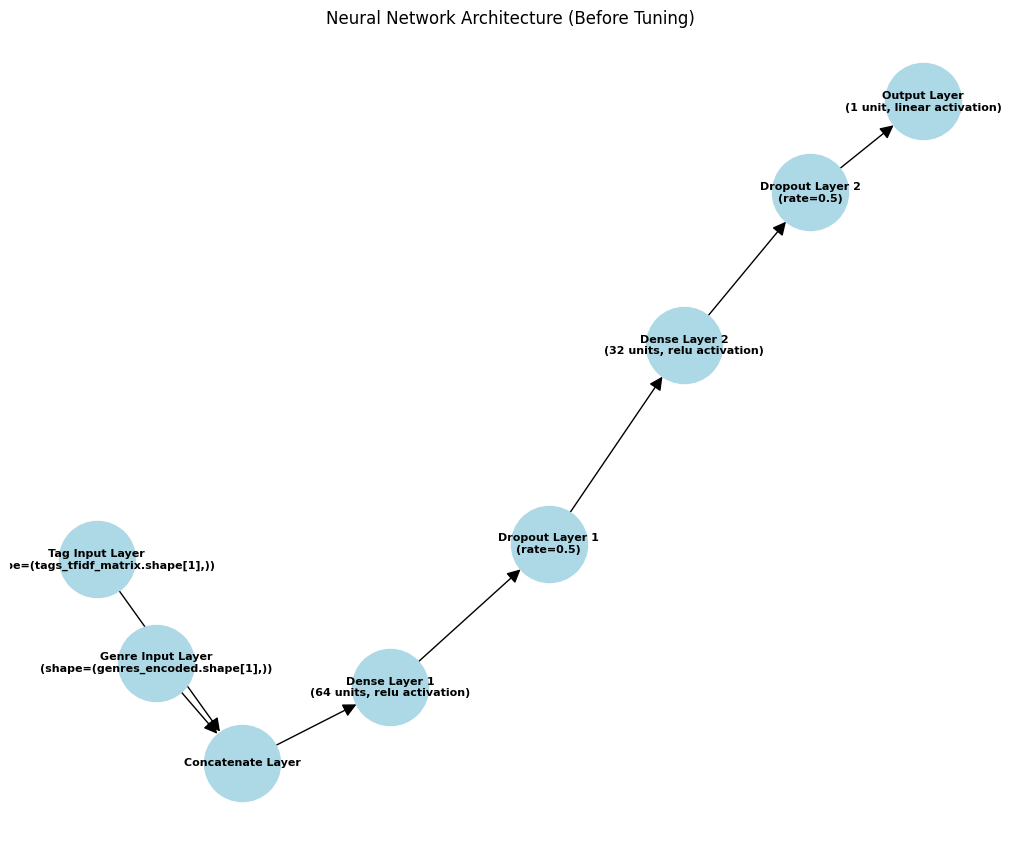

In [114]:
# Visualize Neural Network structure(before modifying) 
# Create a graph object
G = nx.DiGraph()

# Add nodes (represent layers)
G.add_node("Genre Input Layer\n(shape=(genres_encoded.shape[1],))")
G.add_node("Tag Input Layer\n(shape=(tags_tfidf_matrix.shape[1],))")
G.add_node("Concatenate Layer")
G.add_node("Dense Layer 1\n(64 units, relu activation)")
G.add_node("Dropout Layer 1\n(rate=0.5)")
G.add_node("Dense Layer 2\n(32 units, relu activation)")
G.add_node("Dropout Layer 2\n(rate=0.5)")
G.add_node("Output Layer\n(1 unit, linear activation)")

# Add edges (represent flow of data)
G.add_edges_from([("Genre Input Layer\n(shape=(genres_encoded.shape[1],))", "Concatenate Layer"),
                  ("Tag Input Layer\n(shape=(tags_tfidf_matrix.shape[1],))", "Concatenate Layer"),
                  ("Concatenate Layer", "Dense Layer 1\n(64 units, relu activation)"),
                  ("Dense Layer 1\n(64 units, relu activation)", "Dropout Layer 1\n(rate=0.5)"),
                  ("Dropout Layer 1\n(rate=0.5)", "Dense Layer 2\n(32 units, relu activation)"),
                  ("Dense Layer 2\n(32 units, relu activation)", "Dropout Layer 2\n(rate=0.5)"),
                  ("Dropout Layer 2\n(rate=0.5)", "Output Layer\n(1 unit, linear activation)")])

# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Generates the layout for the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=8, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=20)
plt.title("Neural Network Architecture (Before Tuning)")
plt.show()


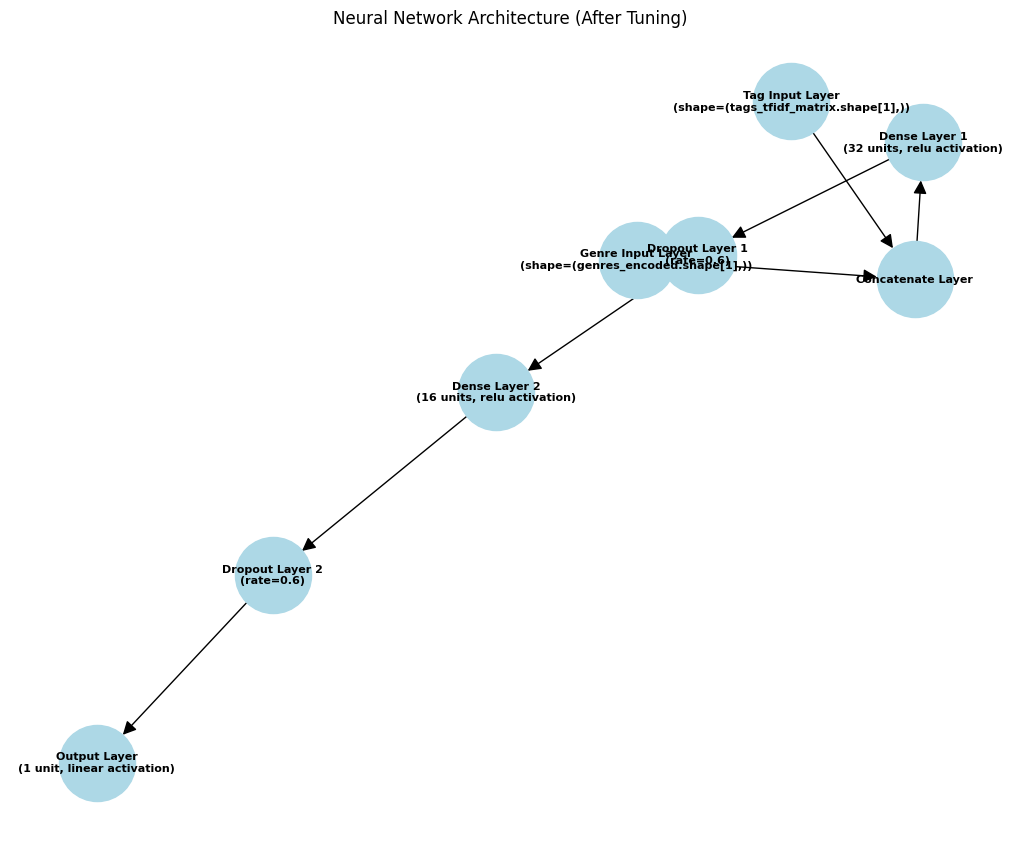

In [115]:
# Visualize Neural Network structure(after modifying) 

# Create a graph object
G = nx.DiGraph()

# Add nodes (represent layers)
G.add_node("Genre Input Layer\n(shape=(genres_encoded.shape[1],))")
G.add_node("Tag Input Layer\n(shape=(tags_tfidf_matrix.shape[1],))")
G.add_node("Concatenate Layer")
G.add_node("Dense Layer 1\n(32 units, relu activation)")
G.add_node("Dropout Layer 1\n(rate=0.6)")
G.add_node("Dense Layer 2\n(16 units, relu activation)")
G.add_node("Dropout Layer 2\n(rate=0.6)")
G.add_node("Output Layer\n(1 unit, linear activation)")

# Add edges (represent flow of data)
G.add_edges_from([("Genre Input Layer\n(shape=(genres_encoded.shape[1],))", "Concatenate Layer"),
                  ("Tag Input Layer\n(shape=(tags_tfidf_matrix.shape[1],))", "Concatenate Layer"),
                  ("Concatenate Layer", "Dense Layer 1\n(32 units, relu activation)"),
                  ("Dense Layer 1\n(32 units, relu activation)", "Dropout Layer 1\n(rate=0.6)"),
                  ("Dropout Layer 1\n(rate=0.6)", "Dense Layer 2\n(16 units, relu activation)"),
                  ("Dense Layer 2\n(16 units, relu activation)", "Dropout Layer 2\n(rate=0.6)"),
                  ("Dropout Layer 2\n(rate=0.6)", "Output Layer\n(1 unit, linear activation)")])


# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Generates the layout for the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=8, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=20)
plt.title("Neural Network Architecture (After Tuning)")
plt.show()


In [116]:
# Convert the tags_tfidf_matrix to an array outside of the function
tags_array = tags_tfidf_matrix.toarray()

def genre_tag_based_nn_recommendation(movie_title, merged_data_copy, genres_encoded, tags_array, model, n_recommendations=10):
    """
    Neural network-based movie recommendation system using genre and tag information, with robust input matching.
    
    Parameters:
    - movie_title (str): The title of the movie to search.
    - merged_data (DataFrame): The DataFrame containing the movie data with genre and tag features.
    - genre_db (np.array): The genre features of all movies (same order as merged_data).
    - tag_db (np.array): The tag features of all movies (same order as merged_data).
    - model (keras.Model): The trained neural network model.
    - n_recommendations (int): The number of movie recommendations to return.
    
    Returns:
    - recommended_movies (list of tuples): A list of recommended movie titles and their predicted scores.
    """
    
    # Find the closest matching movie title
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find closest match
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")
    
    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    
    # Find the corresponding movie index
    movie_idx = merged_data[merged_data['title'] == original_matched_title].index[0]
    
    # Extract the genre and tag features for the input movie
    input_genre = genres_encoded[movie_idx].reshape(1, -1)  # Reshape to match model input
    input_tag = tags_array[movie_idx].reshape(1, -1)      # Reshape to match model input
    
    # Predict the scores for all movies in the database
    predicted_scores = model.predict([genres_encoded, tags_array], verbose=0).flatten()  # Predict for all movies
    
    # Sort the movies by predicted scores, excluding the input movie itself
    sorted_indices = np.argsort(predicted_scores)[::-1]  # Sort by scores in descending order
    
    # Collect top unique recommended movies
    recommended_movies = []
    seen_titles = set()  # To track unique movie titles
    
    for idx in sorted_indices:
        recommended_movie_title = merged_data.iloc[idx]['title']
        predicted_score = predicted_scores[idx]  # Get the predicted score
        
        # Skip duplicates and the original input movie itself
        if recommended_movie_title not in seen_titles and recommended_movie_title != original_matched_title:
            seen_titles.add(recommended_movie_title)
            recommended_movies.append((recommended_movie_title, predicted_score))
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    return recommended_movies[:n_recommendations]

# test this function
result_nn = genre_tag_based_nn_recommendation('frozen', merged_data_copy, genres_encoded, tags_array, model, n_recommendations=10)
result_nn

[('The Shawshank Redemption (1994)', 4.978202),
 ('Fight Club (1999)', 4.970436),
 ('Amelie (2001)', 4.92037),
 ('Eternal Sunshine of the Spotless Mind (2004)', 4.916696),
 ('The Man from Earth (2007)', 4.88262),
 ('Twelve Monkeys (1995)', 4.8535175),
 ('The Place Promised in Our Early Days (2004)', 4.8332806),
 ('Inception (2010)', 4.825331),
 ('Waking Life (2001)', 4.819276),
 ('Donnie Darko (2001)', 4.7900505)]

####### bad recommendation...so will use sentencetransformer

#####find a place earlier to explain why no inferential tests

In [117]:
merged_data_copy.columns

Index(['userId', 'movieId', 'title', 'genres', 'director', 'rating',
       'timestamp', 'tag', 'userId_encoded', 'movieId_encoded',
       'director_encoded'],
      dtype='object')

In [118]:
# Start the timer
start_time = time.time()

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

# Define a function to generate embedding vectors for movies
def generate_movie_embeddings(merged_data_copy, batch_size=16):
    # Start the timer for embedding generation
    embedding_start_time = time.time()

    genre_embeddings = model.encode(merged_data_copy['genres'].tolist(), batch_size=batch_size)  
    tag_embeddings = model.encode(merged_data_copy['tag'].tolist(), batch_size=batch_size)     
    
    # Combine genre and tag and average them
    combined_embeddings = (genre_embeddings + tag_embeddings) / 2

    # Embedding generation time
    embedding_end_time = time.time()
    print(f"Embeddings generated in {embedding_end_time - embedding_start_time:.2f} seconds")
    
    return combined_embeddings

# Generate movie embedding vectors
movie_embeddings = generate_movie_embeddings(merged_data_copy, batch_size=16)

# Total execution time
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

# Check the shape
movie_embeddings.shape

Embeddings generated in 324.75 seconds
Total execution time: 326.08 seconds


(126083, 384)

In [119]:
def recommend_movies_based_on_genre_and_tag(movie_title, merged_data_copy, movie_embeddings, n_recommendations=10):
    """
    Recommends movies based on embedding similarity using cosine similarity, searched by movie title.

    Parameters:
    movie_title (str): The title of the movie to search.
    merged_data_copy (DataFrame): The DataFrame containing the movie data.
    movie_embeddings (ndarray): The embedding matrix representing the movies.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of tuples with recommended movie titles and their corresponding similarity scores.
    """
    
    # Find the closest matching movie title and its corresponding movieId
    all_titles = merged_data_copy['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find the closest match
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data_copy[merged_data_copy['title'].str.lower() == matched_title]['title'].values[0]
    
    # Find the corresponding movie ID and index
    movie_id = merged_data_copy[merged_data_copy['title'] == original_matched_title]['movieId'].values[0]
    
    # Ensure the movie ID exists in the dataset
    if movie_id not in merged_data_copy['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found.")
    
    # Get the index and embedding vector of the target movie
    movie_idx = merged_data_copy[merged_data_copy['movieId'] == movie_id].index[0]
    movie_vector = movie_embeddings[movie_idx].reshape(1, -1)
    
    # Compute cosine similarity between the target movie and all others
    similarity_scores = cosine_similarity(movie_vector, movie_embeddings).flatten()
    
    # Get indices of top similar movies (excluding itself)
    similar_indices = similarity_scores.argsort()[::-1][1:]  # Get all similar movies, excluding the first one (itself)
    
    # Collect recommended movie titles with similarity scores
    recommended_movies = []
    seen_titles = set()  # To keep track of unique movie titles
    
    for idx in similar_indices:
        movie_title = merged_data_copy.iloc[idx]['title']
        similarity_score = similarity_scores[idx]  # Get the similarity score
        
        # Only add unique movie titles (skip duplicates and the original movie)
        if movie_title not in seen_titles and movie_title != original_matched_title:
            seen_titles.add(movie_title)
            recommended_movies.append((movie_title, similarity_score))  # Append as a tuple (title, score)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    # If we don't have enough recommendations, we keep adding more similar ones
    while len(recommended_movies) < n_recommendations:
        for idx in similar_indices:
            movie_title = merged_data_copy.iloc[idx]['title']
            similarity_score = similarity_scores[idx]
            
            if movie_title not in seen_titles and movie_title != original_matched_title:
                seen_titles.add(movie_title)
                recommended_movies.append((movie_title, similarity_score))
            
            if len(recommended_movies) >= n_recommendations:
                break
    
    # Return exactly the requested number of recommendations
    return recommended_movies[:n_recommendations]

# Test the function
recommended_movies = recommend_movies_based_on_genre_and_tag('hello', merged_data_copy, movie_embeddings, n_recommendations=5)
recommended_movies

[('Flirting (1991)', 1.0),
 ('Butterfly (1982)', 1.0),
 ('The Last Temptation of Christ (1988)', 1.0),
 ('Restoration (1995)', 1.0),
 ('Do the Right Thing (1989)', 1.0)]

In [120]:
def combined_recommendation_v2(movie_title_or_id, merged_data_copy, movie_embeddings, n_recommendations=5):
    """
    Combines recommendations based on movie embeddings (genres and tags) and director-based recommendations,
    without applying any specific weights to different recommendation sources.
    
    Parameters:
    movie_title_or_id (str or int): The title of the movie or user ID to search.
    merged_data_copy (DataFrame): The DataFrame containing the movie data.
    movie_embeddings (ndarray): The embedding matrix representing the movies.
    n_recommendations (int): The number of similar movie recommendations to return (default is 5).
    
    Returns:
    A list of recommended movie titles.
    """

    # Initialize variables to store recommendations
    genre_tag_similar_movies = []
    director_recommendations = []

    # Get genre and tag based recommendations (using embeddings)
    genre_tag_similar_movies = recommend_movies_based_on_genre_and_tag(movie_title_or_id, merged_data_copy, movie_embeddings, 10)

    # Get director-based recommendations if available (list of movie titles)
    director_recommendations = recommend_movies_by_director(movie_title_or_id, merged_data_copy, n_recommendations=2)

    # Combine recommendations (starting with director-based if available)
    combined_recommendations = []

    # Prioritize director recommendations (1 or 2 movies)
    num_director_movies = min(2, len(director_recommendations))  # Take 1 or 2 movies from director recommendations
    combined_recommendations.extend(director_recommendations[:num_director_movies])

    # Calculate the remaining number of movies to pick from genre and tag recommendations
    remaining_slots = n_recommendations - len(combined_recommendations)  # Remaining slots after picking director movies

    # Add movies from genre and tag recommendations (without duplicates)
    genre_tag_movies_to_add = [movie for movie, _ in genre_tag_similar_movies if movie.lower() not in [m.lower() for m in combined_recommendations]][:remaining_slots]
    combined_recommendations.extend(genre_tag_movies_to_add)

    # Return only the movie titles, ensuring there are exactly `n_recommendations`
    return combined_recommendations[:n_recommendations]

# Example usage:
result = combined_recommendation_v2('burning', merged_data_copy, movie_embeddings, n_recommendations=5)
result

['Friday the 13th Part V: A New Beginning (1985)',
 'Friday the 13th Part 3: 3D (1982)',
 'Friday the 13th Part IV: The Final Chapter (1984)',
 'Friday the 13th (2009)',
 'Halloween II (1981)']

##### 

In [121]:
def combined_user_and_movie_recommendation(user_input):
    """
    Combines recommendations based on user ID and movie title.
    If user input is an ID, it returns user-based recommendations.
    If user input is a movie title, it returns content-based recommendations.
    
    Parameters:
    user_input (str): User input, either a user ID or a movie title.
    
    Returns:
    A string with recommended movie titles or an error message if movie title not found.
    """
    try:
        # Try to parse the input as a user ID (integer)
        user_id = int(user_input)
        # Use SVD-based recommendation for user ID
        user_recommendations = get_user_based_recommendations(user_id, final_merged_data, best_svd, n_recommendations=5)
        return "\n".join(user_recommendations)
    
    except ValueError:
        # If the input is not a number, treat it as a movie title
        try:
            # Directly call combined_recommendation_v2 without converting or checking manually
            movie_recommendations = combined_recommendation_v2(user_input, merged_data_copy, movie_embeddings, n_recommendations=5)
            return "\n".join(movie_recommendations)
        except ValueError:
            # If combined_recommendation_v2 raises a ValueError, return "Oops"
            return "Oops, no movie found with a title similar to '{}'.".format(user_input)


# Create Gradio interface with a single input for user ID or movie title
interface = gr.Interface(
    fn=combined_user_and_movie_recommendation,
    inputs=gr.Textbox(label="Enter User ID or Movie Title"),
    outputs=gr.Textbox(label="Recommended Movies"),
    title="Charlotte's Movie Recommendation System 2.0",
    description="Enter a user ID for personalized recommendations, or a movie title for content-based recommendations."
)

# Launch the Gradio interface
interface.launch(share=True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://a6273428542466efe8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
